# 1. Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdive')

In [ ]:
import numpy as np
import pandas as pd
import glob
import random 

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

# 2. Model baseline

<b> In this chapter we will train a model directly from the pictures and see what accuracy we can obtain.</b>

## 2.1. Loading data

<b>There are 315 species pictures organized in as many folders:</b>

In [ ]:
filelist = glob.glob('.../input/100-bird-species/valid/*')
species = [fname.split("/")[-1] for fname in filelist]
species[0:5] + ["..."]

['WATTLED CURASSOW',
 'CARMINE BEE-EATER',
 'GAMBELS QUAIL',
 'UMBRELLA BIRD',
 'AMERICAN KESTREL',
 '...']

<b>There are three sets already defined, the train set / test set / validation set:</b>

In [ ]:
datasets = ["train", "test", "valid"]

<b>As described in the dataset documentation, all the pictures are of size 224 x 224. Using the pictures as they are without resizing them will result in kernel crash due to memory limitations. Let's load the pictures after having resized them lower. Here we divide their size by 4.</b>

In [ ]:
im_width = round(224/4)
im_height = round(224/4)
print("Image new width: " + str(im_width))
print("Image new height: " + str(im_height))

Image new width: 56
Image new height: 56


<b>Let's load the pictures:</b>

In [ ]:
%%time

data = dict({"train": [], "test": [], "valid": []})
target = dict({"train": [], "test": [], "valid": []})

for set_ in datasets:
    for spec in species:
        filelist = glob.glob('.../input/100-bird-species/' + set_ + '/' + spec + '/*.jpg')
        target[set_].extend([spec for _ in filelist])
        data[set_].extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
    data[set_] = np.stack(data[set_], axis=0)

CPU times: user 1min 15s, sys: 5.39 s, total: 1min 21s
Wall time: 5min 9s


<b>So we have:</b><br>
<ul>
    <li><b>A train set of 45278 tensor images</b></li>
    <li><b>A test set of 1550 tensor images</b></li>
    <li><b>A validation set of 1550 tensor images</b></li>
    </ul>
    <b>Each image is of size 56 x 56 and each of their pixels is defined by three colors R, G, B.</b>

In [ ]:
print("train set shape: " + str(data["train"].shape))
print("test set shape: " + str(data["test"].shape))
print("validation set shape: " + str(data["valid"].shape))

train set shape: (45980, 56, 56, 3)
test set shape: (1575, 56, 56, 3)
validation set shape: (1575, 56, 56, 3)


<b>We can have an overview of some random resized images and the associated specie:</b>

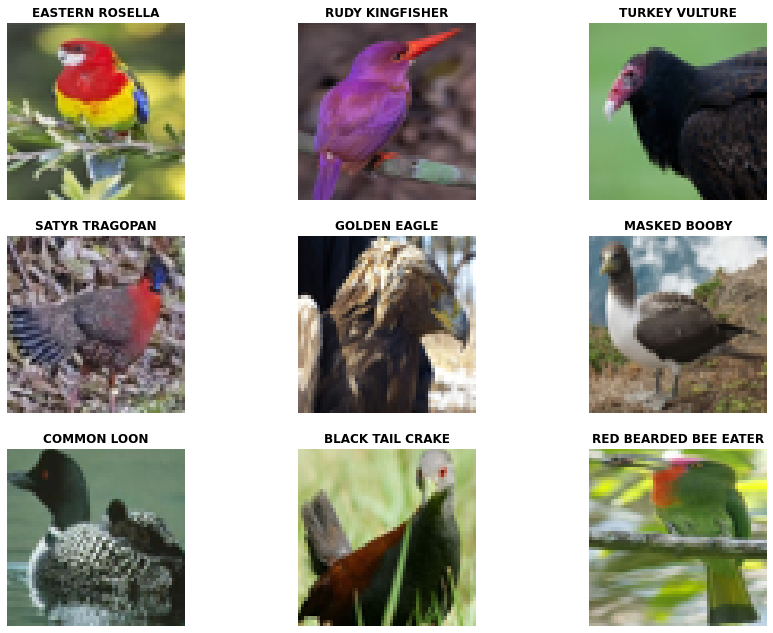

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data["train"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(target["train"][num_image], fontdict={"fontweight": 700})
        ax.imshow(data["train"][num_image]);

<b>As the sets are already set for us, we don't need to use</b> `train_test_split`.

# 2.2. Preparing the data

### Normalization

<b>To ease the convergence of the algorithm, it is usefull to normalize the data. We have color values between 0 and 255, we are going to set them between 0 and 1 by dividing by 255.</b>

In [ ]:
print(data["train"].max())
print(data["train"].min())

255
0


In [ ]:
data_norm = data.copy()

In [ ]:
data_norm["train"] = np.round((data_norm["train"]/255), 3)
data_norm["test"] = np.round((data_norm["test"]/255), 3)
data_norm["valid"] = np.round((data_norm["valid"]/255), 3)

<b>Here again, we can check the normalized pictures randomly:</b>

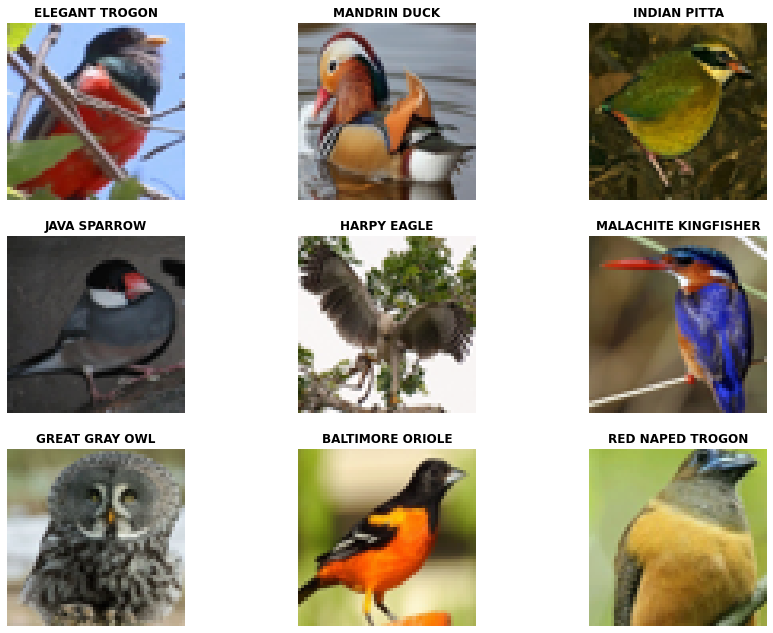

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data_norm["train"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(target["train"][num_image], fontdict={"fontweight": 700})
        ax.imshow(data_norm["train"][num_image]);

### Target encoding

<b>Here we convert targets first from string to numerical values, each category becoming an integer, from 0 to 315 (as there are 315 different bird species to classify):</b>

<b>Fitting the encoder on train set:</b>

In [ ]:
encoder = LabelEncoder().fit(target["train"])

<b>Applying on all train, test and validation sets:</b>

In [ ]:
target_cat = target.copy()

In [ ]:
target_cat["train"] = encoder.transform(target_cat["train"])
target_cat["test"] = encoder.transform(target_cat["test"])
target_cat["valid"] = encoder.transform(target_cat["valid"])

<b>And now, we convert the result to one-hot encoded target so that they can be used to train a classification neural network. We use</b> `to_categorical` <b>from tensorflow library:</b>

In [ ]:
target_ohe = target_cat.copy()

In [ ]:
target_ohe["train"] = to_categorical(target_ohe["train"])
target_ohe["test"] = to_categorical(target_ohe["test"])
target_ohe["valid"] = to_categorical(target_ohe["valid"])

In [ ]:
pd.DataFrame(target_ohe["test"]).head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3. Convolutionnal neural network

Now, let's define the Convolutional Neural Network.

The CNN that is composed of:

◼️ Conv2D layer with 32 filters, a kernel size of (3, 3), the relu activation function, a padding equal to same and the correct input_shape<br>
◼️ MaxPooling2D layer with a pool size of (2, 2)<br>
◼️ Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to same<br>
◼️ MaxPooling2D layer with a pool size of (2, 2)<br>
◼️ Conv2D layer with 128 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to same<br>
◼️ MaxPooling2D layer with a pool size of (3, 3)<br>
◼️ Flatten layer<br>
◼️ dense function with 120 neurons with the relu activation function<br>
◼️ dense function with 60 neurons with the relu activation function<br>
◼️ dropout layer (with a rate of 0.5), to regularize the network<br>
◼️ dense function related to the task: multiclass (315) classification > softmax

In [ ]:
def initialize_model(name):
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(315, activation='softmax'))

    return model

In [ ]:
model = initialize_model(name="baseline")
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 56, 56, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0  

In [ ]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
    return model

<b>Here let's the following parameters:</b><br> ◼️ an early stopping after 5 epochs and set the parameter </b>`restore_best_weights` to `True` so that the weights of best score on monitored metric - here `val_accuracy` (accuracy on test set) - are restored when training stops. This way the model has the best accuracy possible on unseen data.<br>◼️ add the `ReduceLROnPlateau` parameter set on `val_loss` with a `patience` parameter set on 1 and a `factor` parameter set on 0.5 so that the learning rate is reduced by 2 whenever the `val_loss` parameter starts increasing

In [ ]:
model_baseline = initialize_model(name="baseline")
model_baseline = compile_model(model_baseline)
#
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]
#
history_baseline = model_baseline.fit(data_norm["train"], target_ohe["train"],
                                      batch_size=16,
                                      epochs=1000,
                                      validation_data=(data_norm["valid"], target_ohe["valid"]),
                                      callbacks=callback)

2021-11-08 10:41:18.636984: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1730319360 exceeds 10% of free system memory.
2021-11-08 10:41:20.511372: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1730319360 exceeds 10% of free system memory.


Epoch 1/1000


2021-11-08 10:41:23.096161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2874/2874 [==============================] - 19s 4ms/step - loss: 5.2357 - accuracy: 0.0274 - val_loss: 4.2749 - val_accuracy: 0.0952
Epoch 2/1000
2874/2874 [==============================] - 12s 4ms/step - loss: 4.1056 - accuracy: 0.1311 - val_loss: 3.4393 - val_accuracy: 0.2343
Epoch 3/1000
2874/2874 [==============================] - 13s 4ms/step - loss: 3.5422 - accuracy: 0.2164 - val_loss: 2.8679 - val_accuracy: 0.3378
Epoch 4/1000
2874/2874 [==============================] - 12s 4ms/step - loss: 3.1889 - accuracy: 0.2798 - val_loss: 2.5675 - val_accuracy: 0.4057
Epoch 5/1000
2874/2874 [==============================] - 12s 4ms/step - loss: 2.9267 - accuracy: 0.3273 - val_loss: 2.3700 - val_accuracy: 0.4324
Epoch 6/1000
2874/2874 [==============================] - 12s 4ms/step - loss: 2.7287 - accuracy: 0.3638 - val_loss: 2.1637 - val_accuracy: 0.4775
Epoch 7/1000
2874/2874 [==============================] - 12s 4ms/step - loss: 2.5851 - accuracy: 0.3920 - val_loss: 2.0897 - val_a

## 2.4. Results

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

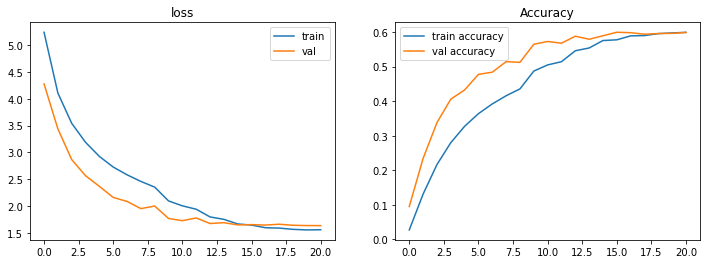

In [ ]:
plot_history(history_baseline, title='', axs=None, exp_name="");

In [ ]:
model_baseline.evaluate(data_norm["test"], target_ohe["test"], verbose=0)

[1.573203444480896, 0.6095238327980042]

<b>So we have an accuracy on unseen data of almost 61%.</b><br><b>Let's see some random images associated with their true label and predicted label:</b>

In [ ]:
y_pred = [np.argmax(val) for val in list(model_baseline.predict(data_norm["test"]))]
y_true = target_cat["test"].copy()

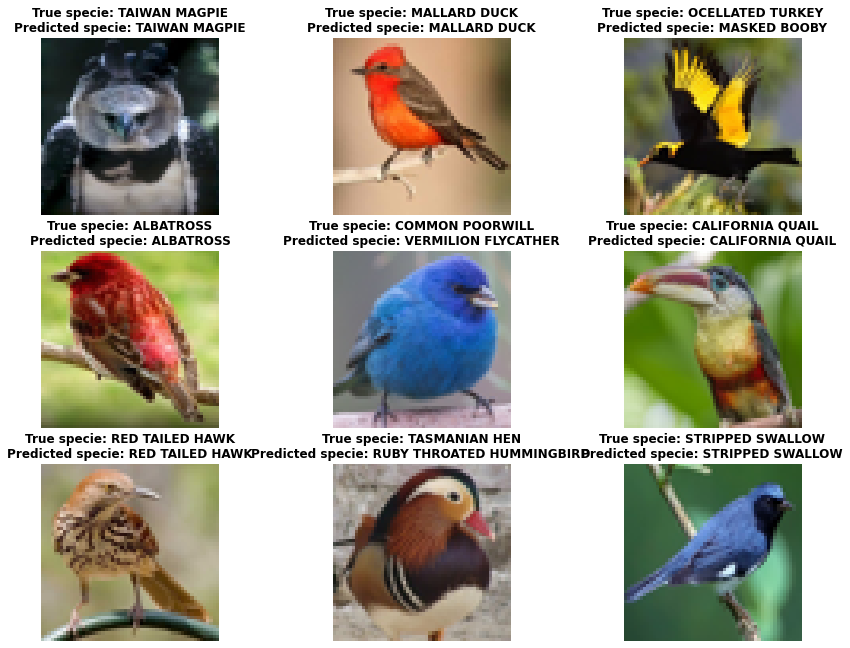

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data_norm["test"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("True specie: " + str(target["test"][y_true[num_image]] + "\nPredicted specie: " + target["test"][y_pred[num_image]]), fontdict={"fontweight": 700})
        ax.imshow(data["test"][num_image]);

<b>We can see as expected there are some fails with 61% accuracy.</b>

# 3. Model improved with data augmentation

<b>Here we are going to use </b>`ImageDataGenerator`<b> which generate batches of tensor image data with real-time data augmentation, to see by how much we can increase the accuracy of the previous model.</b><br><br>◼️ In this case, the only parameter used for `ImageDataGenerator` is `recale` which is the rescaling factor. It multiplies the data by the value provided, here 1/255 which is normalisation (in this case, not using `rescale=1/255` won't work at all ...) <br>◼️ the batch sizes are 64<br>◼️ the target size is set to image original size 224 x 224

## 3.1. Prepare image flow

In [ ]:
datagen = ImageDataGenerator(rescale=1/255)
#
train_generator = datagen.flow_from_directory('/kaggle/input/100-bird-species/train',
                                               batch_size=64,
                                               target_size=(224,224)
                                             )
#
validation_generator = datagen.flow_from_directory('/kaggle/input/100-bird-species/valid',
                                                   batch_size=64,
                                                   target_size=(224,224)
                                                  )

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


<b>We can have an overview of images from the data generator:</b>

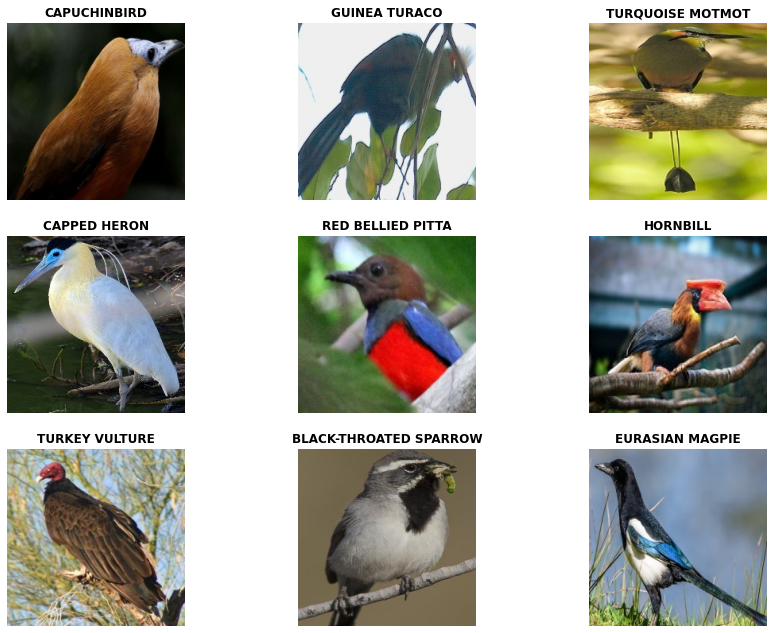

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = train_generator.next()
        label_id = list(label[0]).index(1)
        label_str = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);

## 3.2. Model

<b>Let's prepare a model to train from the image generator.</b><br>
The CNN is composed of:

◼️ Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, a padding equal to same and the correct input_shape<br>
◼️ Another Conv2D layer with 64 filters, a kernel size of (3, 3) and the relu activation function<br>
◼️ a dropout layer (with a rate of 0.4), to regularize the network<br>
◼️ batch normalization layer which applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1<br>
◼️ a MaxPooling2D layer with a pool size of (2, 2)<br>
◼️ Another Conv2D layer with 64 filters, a kernel size of (3, 3) and the relu activation function<br>
◼️ Two more MaxPooling2D layer with a pool size of (2, 2)<br>
◼️ a dropout layer (with a rate of 0.5), to regularize the network<br>
◼️ another batch normalization layer<br>
◼️ Flatten layer<br>
◼️ dense function with 512 neurons with the relu activation function<br>
◼️ a dropout layer (with a rate of 0.5), to regularize the network<br>
◼️ another batch normalization layer<br>
◼️ dense function related to the task: multiclass (315) classification > softmax

In [ ]:
def initialize_model_da(name):
    model_da = Sequential(name=name)
    model_da.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3), padding='same'))
    model_da.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model_da.add(layers.Dropout(rate=0.4))
    model_da.add(layers.BatchNormalization())
    model_da.add(layers.MaxPool2D(pool_size=(2, 2)))
    model_da.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model_da.add(layers.MaxPool2D(pool_size=(2, 2)))
    model_da.add(layers.MaxPool2D(pool_size=(2, 2)))
    model_da.add(layers.Dropout(rate=0.5))
    model_da.add(layers.BatchNormalization())
    model_da.add(layers.Flatten())
    model_da.add(layers.Dense(512, activation='relu'))
    model_da.add(layers.Dropout(rate=0.5))
    model_da.add(layers.BatchNormalization())
    model_da.add(layers.Dense(315, activation='softmax'))
    
    return model_da

In [ ]:
model_da = initialize_model_da(name="data-aug")
model_da.summary()

Model: "data-aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 222, 222, 64)      36928     
_________________________________________________________________
dropout_29 (Dropout)         (None, 222, 222, 64)      0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 222, 222, 64)      256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 54, 54, 64)        0  

In [ ]:
def compile_model_da(model):
    model_da.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics="accuracy")
    return model_da

<b> Here the same parameters used for previous training are used. As the training is very long, the epoch limit is set to 25.</b>

In [ ]:
model_da = initialize_model_da(name="data-aug")
model_da = compile_model_da(model_da)
#
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history_da = model_da.fit(train_generator,
                          epochs=25,
                          validation_data=validation_generator,
                          callbacks=callback)

Epoch 1/25
719/719 [==============================] - 153s 212ms/step - loss: 4.1534 - accuracy: 0.1741 - val_loss: 2.9596 - val_accuracy: 0.3638
Epoch 2/25
719/719 [==============================] - 165s 230ms/step - loss: 2.5267 - accuracy: 0.4297 - val_loss: 2.7502 - val_accuracy: 0.4070
Epoch 3/25
719/719 [==============================] - 174s 241ms/step - loss: 1.7728 - accuracy: 0.5767 - val_loss: 2.2538 - val_accuracy: 0.4756
Epoch 4/25
719/719 [==============================] - 163s 227ms/step - loss: 1.2850 - accuracy: 0.6775 - val_loss: 2.5984 - val_accuracy: 0.4222

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/25
719/719 [==============================] - 163s 227ms/step - loss: 0.7800 - accuracy: 0.8006 - val_loss: 1.7925 - val_accuracy: 0.5575
Epoch 6/25
719/719 [==============================] - 155s 215ms/step - loss: 0.5901 - accuracy: 0.8461 - val_loss: 1.7574 - val_accuracy: 0.5784
Epoch 7/25
719/719 [=======================

## 3.3. Results

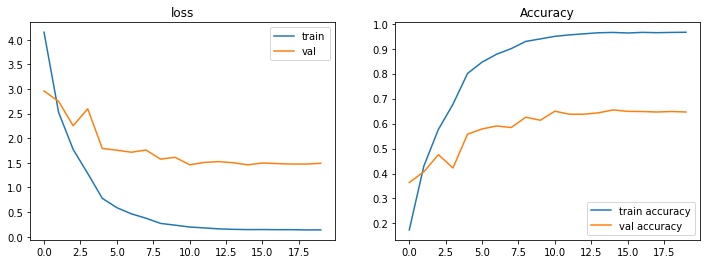

In [ ]:
plot_history(history_da, title='', axs=None, exp_name="");

<b>We see that, although we have a slightly better accuracy than the previous model, we can't really improve it with this method...</b> 

In [ ]:
test_data_da = datagen.flow_from_directory('/kaggle/input/100-bird-species/test',
                                           target_size=(224,224),
                                           batch_size=64)

Found 1575 images belonging to 315 classes.


In [ ]:
model_da.evaluate(test_data_da, verbose=1)

25/25 [==============================] - 6s 246ms/step - loss: 1.3922 - accuracy: 0.6641


[1.3922396898269653, 0.664126992225647]

<b>So with the data augmentation, we have increased the accuracy from 61% to 66%.</b>